10000000.0
27397.260273972603


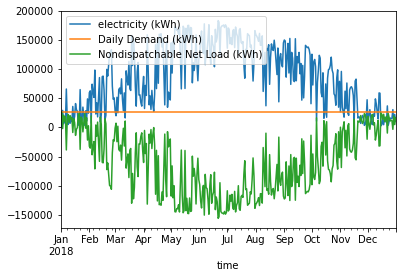

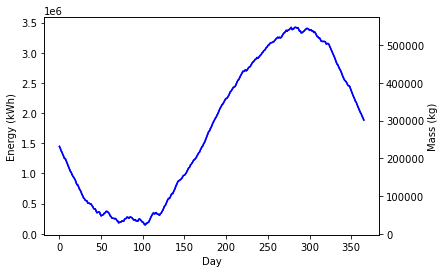

In [14]:
# A piece of code which models hydrogen and ammonia storage separately
# Import all the necessary packages
from dataclasses import dataclass
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import some data
df_epr1MW= pd.read_csv("ninja_pv_51.7520_-1.2578_corrected.csv", index_col=0,parse_dates=True,dayfirst=True, delimiter=",")

#import value used to turn area into power capacity
power_intensity_epr = 90 #W/m2
#use function to lump into useful class

#INPUTS: 1MW hourly dataframe, capacity (W), power intensity W/m^2)
#OUTPUTS: dataframes with specified capacity, annual output, area of that capacity
def Produce_PV_Farm_Structure(DF_HOUR_1MW,CAPACITY,POWER_INTENSITY):
    
    
    capacity_ratio = int(CAPACITY/1e6) #capacity in MW

    #scale up 1MW data figure
    DF_HOUR=DF_HOUR_1MW.multiply(capacity_ratio)
    
    DF_DAY = DF_HOUR.resample("D").sum()
    DF_YEAR = DF_HOUR.resample("Y").sum()
    ANNUAL_OUTPUT = DF_YEAR["electricity (kWh)"].item()
    AREA = CAPACITY/(POWER_INTENSITY)


    @dataclass
    class User(NamedTuple):
        name: str


    # determine the different aspects of the PV_Farm, and the nature of each aspect (float, string etc)
    class PV_Farm(NamedTuple):
        #capacity in W
        Capacity: float
        #dataframe of hourly output
        df_hour: pd.DataFrame
        #dataframe of daily output
        df_day: pd.DataFrame
        #annual production of energy (kWh)
        Annual_Output: float
        #area in metres squared
        Area: float

    PV_Farm_Out = PV_Farm(Capacity=CAPACITY,df_hour=DF_HOUR,df_day=DF_DAY,Annual_Output=ANNUAL_OUTPUT,Area=AREA)

    return PV_Farm_Out

#as example, make class for a 1MW plant
capacity_epr1MW = 1e6 #W
PV_Epr1MW = Produce_PV_Farm_Structure(df_epr1MW,capacity_epr1MW,power_intensity_epr)
#annual demand in Wh; this is the electrical energy which is required for the trains over the course of a year
Annual_Demand_end = 10e6 # =10GWh a year

#daily demand in Wh; this is the electrical energy needed by the trains every day
daily_demand_end = Annual_Demand_end/365

print(Annual_Demand_end)
print(daily_demand_end)

#turn into a vector of the same length as the daily df
NDays = len(PV_Epr1MW.df_day.index)
Daily_Demand_End_Vector = np.zeros(NDays)

for i in range(0,NDays):
    Daily_Demand_End_Vector[i] = daily_demand_end
    i+=1

Daily_Demand_End_List = list(Daily_Demand_End_Vector)

#lump into one dataframe
PV_Epr1MW_supp_demand = PV_Epr1MW.df_day
PV_Epr1MW_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List

PV_Epr1MW_supp_demand['electricity (kWh)'][50]

capacity_a = 28e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()






ratio=[]
ratio1=[]
ratio2=[]
capacity=[]
h_stored2=[]
h_stored2=np.zeros((366,1))
h_max=[]
nh3_max=[]
h_max=np.zeros((20,1))
nh3_max=np.zeros((20,1))
for j in range(30,31,1):
    capacity_a = j*1e6#starting point for capacity of solar farm
    PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
    PV_a_supp_demand = PV_a.df_day
    PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
    PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
    x=0
    x1=0
    x2=0

    demand=15.09e6  #assume to be 15GWh
    daily_H2_demand=demand/365

    capacity.append(j)

    for i in range(365):
        if PV_a_supp_demand['electricity (kWh)'][i]/1.786<daily_H2_demand:
                x=x+1
    y=(365-x+30)/365
    ratio.append(y)
        

        
    h_stored2[0]=30*daily_H2_demand
    for i in range(365):
        daily_h=0 #kwh
        daily_less=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_stored2[i+1]= h_stored2[i]+daily_excess*0.479

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            h_stored2[i+1]= h_stored2[i]-daily_less
        h_stored2[i+1]=h_stored2[i+1]*0.995
        if  h_stored2[i]<=0:
            x1=x1+1
            h_stored2[i]=0
    y1=(365-x1)/365
    ratio1.append(y1)
    
    
    
    h_stored=np.zeros((366,1))
    h_stored[0]=2*daily_H2_demand
    nh3_produced=np.zeros((366,1))
    nh3_produced[0]=0
    defficit=[]
    h_produced=np.zeros((366,1))
    h_produced[0]=0

    nh3_1=np.zeros((366,1))     #kwh
    nh3_1[0]=35*daily_H2_demand

    for i in range(365):
        daily_nh3=0 #kwh
        daily_h=0 #kwh
        daily_less=0
        x=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.75
            #not enough h2 for 14 days
            if 2*daily_H2_demand>h_stored[i]:
                daily_nh3=0   
                daily_h=daily_excess*0.479
                x=h_stored[i]+daily_h
                nh3_1[i+1]=nh3_1[i]
                h_stored[i+1]=x

            if 2*daily_H2_demand<=h_stored[i]:
                excess_h_stored=(h_stored[i]-2*daily_H2_demand)/33.33   #kg
                daily_nh3=(daily_excess)*0.32  #kwh
                daily_nh3_mass=daily_nh3/6.25         #kg
                if excess_h_stored> daily_nh3_mass/17*2:
                        nh3_1[i+1]=nh3_1[i]+daily_nh3
                        daily_h=-daily_nh3_mass/17*2*33.33*0.7
                        x=h_stored[i]+daily_h
                        h_stored[i+1]=x
                        
                    #not enough h2 in storage for production
                if excess_h_stored<= daily_nh3_mass/17*2:
                        nh3_1[i+1]=nh3_1[i]+excess_h_stored*33.33
                        x=h_stored[i]+daily_excess-excess_h_stored*33.33
                        h_stored[i+1]=x
                        h_produced[i+1]=daily_H2_demand+daily_excess*0.56-excess_h_stored*17/2/0.56
            nh3_produced[i+1]=daily_nh3

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            daily_nh3=0
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.56
            if nh3_1[i]>daily_less:
                nh3_1[i+1]=-daily_less+nh3_1[i]
                h_stored[i+1]=h_stored[i]
            if nh3_1[i]<=daily_less:
                daily_h=-daily_less+nh3_1[i]
                nh3_1[i+1]=0
                x=h_stored[i]+daily_h
                h_stored[i+1]=x
            nh3_produced[i+1]=daily_nh3
        h_stored[i+1]=h_stored[i+1]*0.995
        if  h_stored[i]<=0:
            x2=x2+1
            h_stored[i]=0
            print('oh no')
    y2=(365-x2)/365
    ratio2.append(y2)
    h_max[j-20]=max(h_stored)
    nh3_max[j-20]=max(nh3_1)


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(Ndays, nh3_1, 'b-')
ax2.plot(Ndays, nh3_1/6.25, 'b-')

ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh)', color='k')
ax2.set_ylabel('Mass (kg)', color='k')

plt.show()


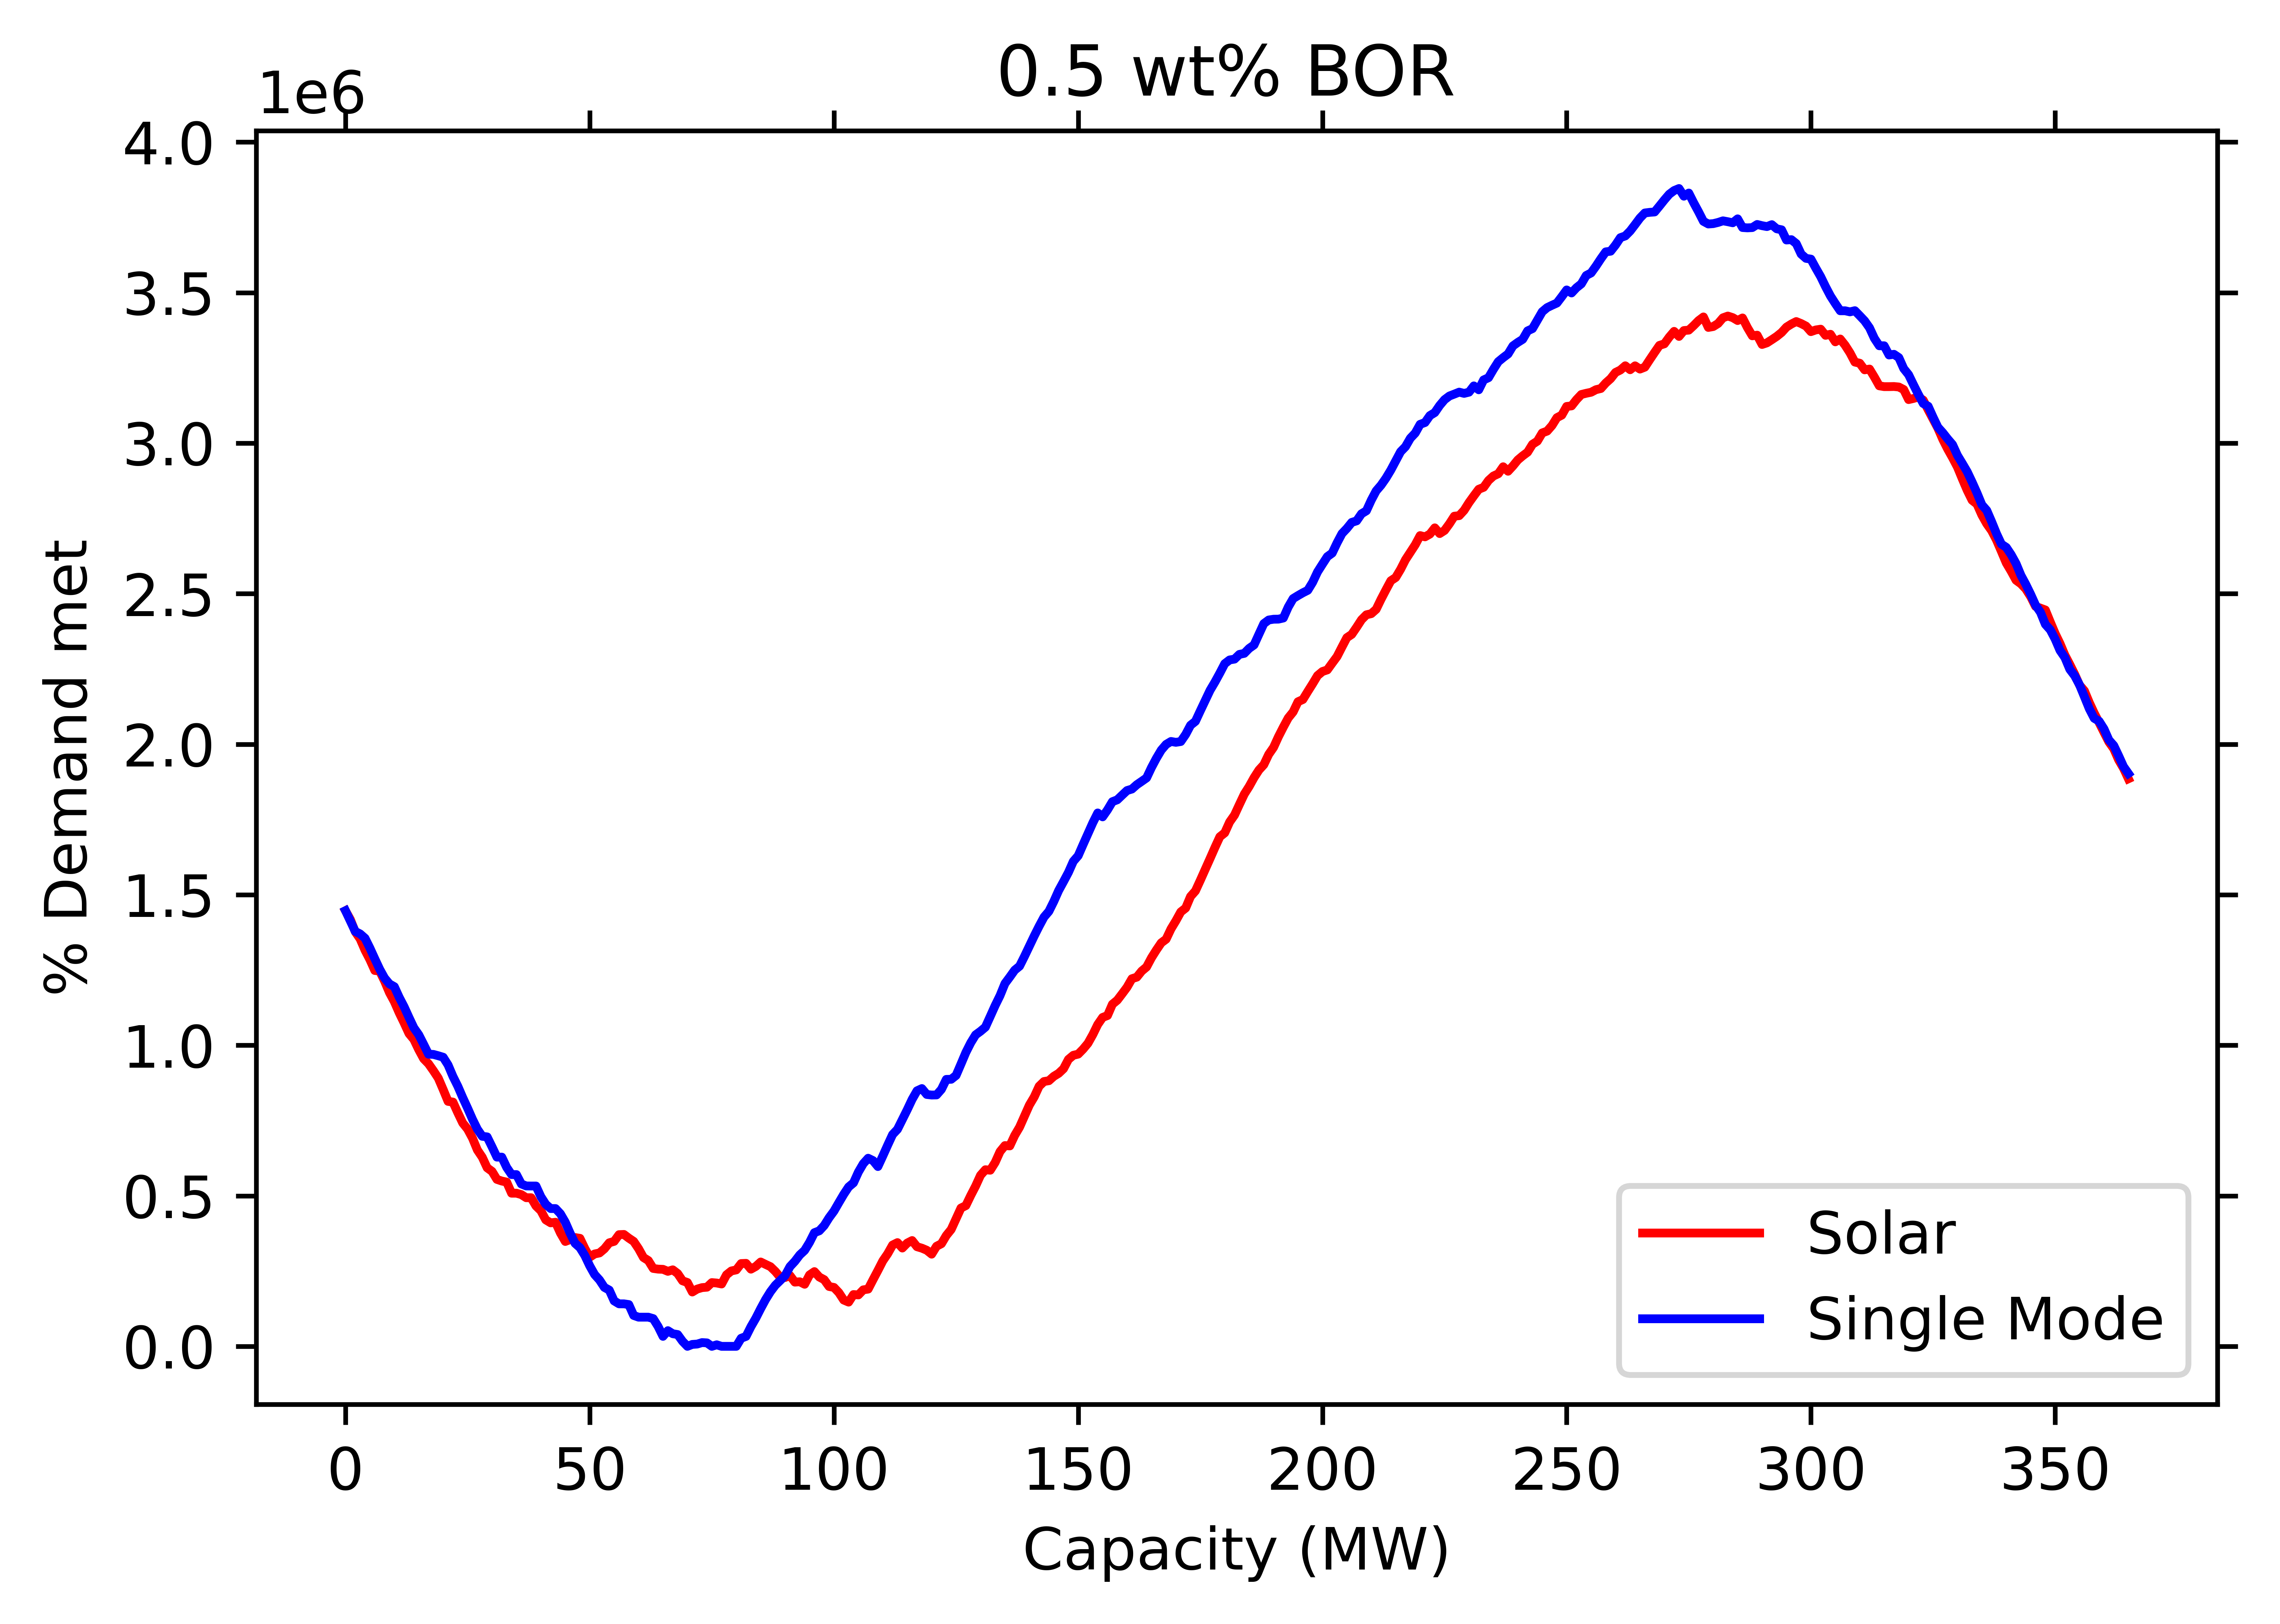

10000000.0
27397.260273972603


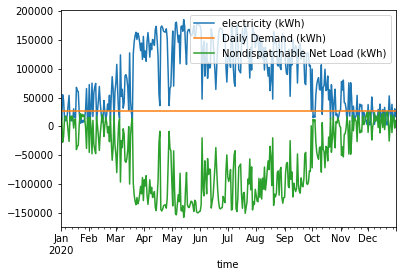

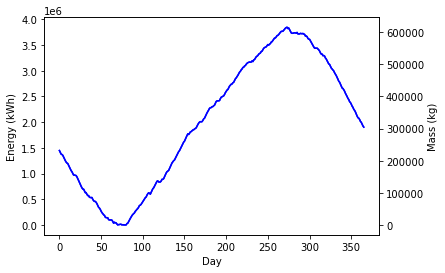

In [15]:
# A piece of code which models hydrogen and ammonia storage separately
# Import all the necessary packages
from dataclasses import dataclass
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import some data
df_epr1MW= pd.read_csv("Oxford_2020.csv", index_col=0,parse_dates=True,dayfirst=True, delimiter=",")

#import value used to turn area into power capacity
power_intensity_epr = 90 #W/m2
#use function to lump into useful class

#INPUTS: 1MW hourly dataframe, capacity (W), power intensity W/m^2)
#OUTPUTS: dataframes with specified capacity, annual output, area of that capacity
def Produce_PV_Farm_Structure(DF_HOUR_1MW,CAPACITY,POWER_INTENSITY):
    
    
    capacity_ratio = int(CAPACITY/1e6) #capacity in MW

    #scale up 1MW data figure
    DF_HOUR=DF_HOUR_1MW.multiply(capacity_ratio)
    
    DF_DAY = DF_HOUR.resample("D").sum()
    DF_YEAR = DF_HOUR.resample("Y").sum()
    ANNUAL_OUTPUT = DF_YEAR["electricity (kWh)"].item()
    AREA = CAPACITY/(POWER_INTENSITY)


    @dataclass
    class User(NamedTuple):
        name: str


    # determine the different aspects of the PV_Farm, and the nature of each aspect (float, string etc)
    class PV_Farm(NamedTuple):
        #capacity in W
        Capacity: float
        #dataframe of hourly output
        df_hour: pd.DataFrame
        #dataframe of daily output
        df_day: pd.DataFrame
        #annual production of energy (kWh)
        Annual_Output: float
        #area in metres squared
        Area: float

    PV_Farm_Out = PV_Farm(Capacity=CAPACITY,df_hour=DF_HOUR,df_day=DF_DAY,Annual_Output=ANNUAL_OUTPUT,Area=AREA)

    return PV_Farm_Out

#as example, make class for a 1MW plant
capacity_epr1MW = 1e6 #W
PV_Epr1MW = Produce_PV_Farm_Structure(df_epr1MW,capacity_epr1MW,power_intensity_epr)
#annual demand in Wh; this is the electrical energy which is required for the trains over the course of a year
Annual_Demand_end = 10e6 # =10GWh a year

#daily demand in Wh; this is the electrical energy needed by the trains every day
daily_demand_end = Annual_Demand_end/365

print(Annual_Demand_end)
print(daily_demand_end)

#turn into a vector of the same length as the daily df
NDays = len(PV_Epr1MW.df_day.index)
Daily_Demand_End_Vector = np.zeros(NDays)

for i in range(0,NDays):
    Daily_Demand_End_Vector[i] = daily_demand_end
    i+=1

Daily_Demand_End_List = list(Daily_Demand_End_Vector)

#lump into one dataframe
PV_Epr1MW_supp_demand = PV_Epr1MW.df_day
PV_Epr1MW_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List

PV_Epr1MW_supp_demand['electricity (kWh)'][50]

capacity_a = 28e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()






ratio=[]
ratio1=[]
ratio2=[]
capacity=[]
h_stored2=[]
h_stored2=np.zeros((366,1))
h_max=[]
nh3_max=[]
h_max=np.zeros((20,1))
nh3_max=np.zeros((20,1))
for j in range(30,31,1):
    capacity_a = j*1e6#starting point for capacity of solar farm
    PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
    PV_a_supp_demand = PV_a.df_day
    PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
    PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
    x=0
    x1=0
    x2=0

    demand=15.09e6  #assume to be 15GWh
    daily_H2_demand=demand/365

    capacity.append(j)

    for i in range(365):
        if PV_a_supp_demand['electricity (kWh)'][i]/1.786<daily_H2_demand:
                x=x+1
    y=(365-x+30)/365
    ratio.append(y)
        

        
    h_stored2[0]=30*daily_H2_demand
    for i in range(365):
        daily_h=0 #kwh
        daily_less=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_stored2[i+1]= h_stored2[i]+daily_excess*0.479

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            h_stored2[i+1]= h_stored2[i]-daily_less
        h_stored2[i+1]=h_stored2[i+1]*0.995
        if  h_stored2[i]<=0:
            x1=x1+1
            h_stored2[i]=0
    y1=(365-x1)/365
    ratio1.append(y1)
    
    
    
    h_stored=np.zeros((366,1))
    h_stored[0]=2*daily_H2_demand
    nh3_produced=np.zeros((366,1))
    nh3_produced[0]=0
    defficit=[]
    h_produced=np.zeros((366,1))
    h_produced[0]=0

    nh3_2=np.zeros((366,1))     #kwh
    nh3_2[0]=35*daily_H2_demand

    for i in range(365):
        daily_nh3=0 #kwh
        daily_h=0 #kwh
        daily_less=0
        x=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.75
            #not enough h2 for 14 days
            if 2*daily_H2_demand>h_stored[i]:
                daily_nh3=0   
                daily_h=daily_excess*0.479
                x=h_stored[i]+daily_h
                nh3_2[i+1]=nh3_2[i]
                h_stored[i+1]=x

            if 2*daily_H2_demand<=h_stored[i]:
                excess_h_stored=(h_stored[i]-2*daily_H2_demand)/33.33   #kg
                daily_nh3=(daily_excess)*0.32  #kwh
                daily_nh3_mass=daily_nh3/6.25         #kg
                if excess_h_stored> daily_nh3_mass/17*2:
                        nh3_2[i+1]=nh3_2[i]+daily_nh3
                        daily_h=-daily_nh3_mass/17*2*33.33*0.7
                        x=h_stored[i]+daily_h
                        h_stored[i+1]=x
                        
                    #not enough h2 in storage for production
                if excess_h_stored<= daily_nh3_mass/17*2:
                        nh3_2[i+1]=nh3_2[i]+excess_h_stored*33.33
                        x=h_stored[i]+daily_excess-excess_h_stored*33.33
                        h_stored[i+1]=x
                        h_produced[i+1]=daily_H2_demand+daily_excess*0.56-excess_h_stored*17/2/0.56
            nh3_produced[i+1]=daily_nh3

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            daily_nh3=0
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.56
            if nh3_2[i]>daily_less:
                nh3_2[i+1]=-daily_less+nh3_2[i]
                h_stored[i+1]=h_stored[i]
            if nh3_2[i]<=daily_less:
                daily_h=-daily_less+nh3_2[i]
                nh3_2[i+1]=0
                x=h_stored[i]+daily_h
                h_stored[i+1]=x
            nh3_produced[i+1]=daily_nh3
        h_stored[i+1]=h_stored[i+1]*0.995
        if  h_stored[i]<=0:
            x2=x2+1
            h_stored[i]=0
            print('oh no')
    y2=(365-x2)/365
    ratio2.append(y2)



fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(Ndays, nh3_2, 'b-')
ax2.plot(Ndays, nh3_2/6.25, 'b-')

ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh)', color='k')
ax2.set_ylabel('Mass (kg)', color='k')

plt.show()



10000000.0
27397.260273972603


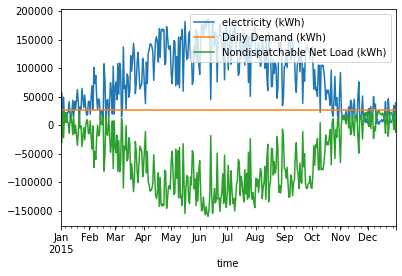

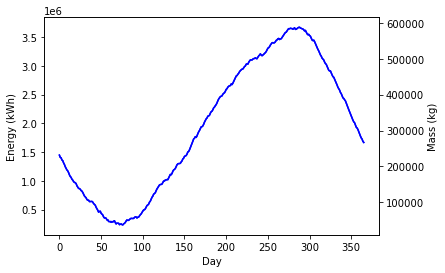

In [17]:
# A piece of code which models hydrogen and ammonia storage separately
# Import all the necessary packages
from dataclasses import dataclass
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import some data
df_epr1MW= pd.read_csv("Birmingham_2015.csv", index_col=0,parse_dates=True,dayfirst=True, delimiter=",")

#import value used to turn area into power capacity
power_intensity_epr = 90 #W/m2
#use function to lump into useful class

#INPUTS: 1MW hourly dataframe, capacity (W), power intensity W/m^2)
#OUTPUTS: dataframes with specified capacity, annual output, area of that capacity
def Produce_PV_Farm_Structure(DF_HOUR_1MW,CAPACITY,POWER_INTENSITY):
    
    
    capacity_ratio = int(CAPACITY/1e6) #capacity in MW

    #scale up 1MW data figure
    DF_HOUR=DF_HOUR_1MW.multiply(capacity_ratio)
    
    DF_DAY = DF_HOUR.resample("D").sum()
    DF_YEAR = DF_HOUR.resample("Y").sum()
    ANNUAL_OUTPUT = DF_YEAR["electricity (kWh)"].item()
    AREA = CAPACITY/(POWER_INTENSITY)


    @dataclass
    class User(NamedTuple):
        name: str


    # determine the different aspects of the PV_Farm, and the nature of each aspect (float, string etc)
    class PV_Farm(NamedTuple):
        #capacity in W
        Capacity: float
        #dataframe of hourly output
        df_hour: pd.DataFrame
        #dataframe of daily output
        df_day: pd.DataFrame
        #annual production of energy (kWh)
        Annual_Output: float
        #area in metres squared
        Area: float

    PV_Farm_Out = PV_Farm(Capacity=CAPACITY,df_hour=DF_HOUR,df_day=DF_DAY,Annual_Output=ANNUAL_OUTPUT,Area=AREA)

    return PV_Farm_Out

#as example, make class for a 1MW plant
capacity_epr1MW = 1e6 #W
PV_Epr1MW = Produce_PV_Farm_Structure(df_epr1MW,capacity_epr1MW,power_intensity_epr)
#annual demand in Wh; this is the electrical energy which is required for the trains over the course of a year
Annual_Demand_end = 10e6 # =10GWh a year

#daily demand in Wh; this is the electrical energy needed by the trains every day
daily_demand_end = Annual_Demand_end/365

print(Annual_Demand_end)
print(daily_demand_end)

#turn into a vector of the same length as the daily df
NDays = len(PV_Epr1MW.df_day.index)
Daily_Demand_End_Vector = np.zeros(NDays)

for i in range(0,NDays):
    Daily_Demand_End_Vector[i] = daily_demand_end
    i+=1

Daily_Demand_End_List = list(Daily_Demand_End_Vector)

#lump into one dataframe
PV_Epr1MW_supp_demand = PV_Epr1MW.df_day
PV_Epr1MW_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List

PV_Epr1MW_supp_demand['electricity (kWh)'][50]

capacity_a = 28e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()






ratio=[]
ratio1=[]
ratio2=[]
capacity=[]
h_stored2=[]
h_stored2=np.zeros((366,1))
h_max=[]
nh3_max=[]
h_max=np.zeros((20,1))
nh3_max=np.zeros((20,1))
for j in range(30,31,1):
    capacity_a = j*1e6#starting point for capacity of solar farm
    PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
    PV_a_supp_demand = PV_a.df_day
    PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
    PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
    x=0
    x1=0
    x2=0

    demand=15.09e6  #assume to be 15GWh
    daily_H2_demand=demand/365

    capacity.append(j)

    for i in range(365):
        if PV_a_supp_demand['electricity (kWh)'][i]/1.786<daily_H2_demand:
                x=x+1
    y=(365-x+30)/365
    ratio.append(y)
        

        
    h_stored2[0]=30*daily_H2_demand
    for i in range(365):
        daily_h=0 #kwh
        daily_less=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_stored2[i+1]= h_stored2[i]+daily_excess*0.479

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            h_stored2[i+1]= h_stored2[i]-daily_less
        h_stored2[i+1]=h_stored2[i+1]*0.995
        if  h_stored2[i]<=0:
            x1=x1+1
            h_stored2[i]=0
    y1=(365-x1)/365
    ratio1.append(y1)
    
    
    
    h_stored=np.zeros((366,1))
    h_stored[0]=2*daily_H2_demand
    nh3_produced=np.zeros((366,1))
    nh3_produced[0]=0
    defficit=[]
    h_produced=np.zeros((366,1))
    h_produced[0]=0

    nh3_3=np.zeros((366,1))     #kwh
    nh3_3[0]=35*daily_H2_demand

    for i in range(365):
        daily_nh3=0 #kwh
        daily_h=0 #kwh
        daily_less=0
        x=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.75
            #not enough h2 for 14 days
            if 2*daily_H2_demand>h_stored[i]:
                daily_nh3=0   
                daily_h=daily_excess*0.479
                x=h_stored[i]+daily_h
                nh3_3[i+1]=nh3_3[i]
                h_stored[i+1]=x

            if 2*daily_H2_demand<=h_stored[i]:
                excess_h_stored=(h_stored[i]-2*daily_H2_demand)/33.33   #kg
                daily_nh3=(daily_excess)*0.32  #kwh
                daily_nh3_mass=daily_nh3/6.25         #kg
                if excess_h_stored> daily_nh3_mass/17*2:
                        nh3_3[i+1]=nh3_3[i]+daily_nh3
                        daily_h=-daily_nh3_mass/17*2*33.33*0.7
                        x=h_stored[i]+daily_h
                        h_stored[i+1]=x
                        
                    #not enough h2 in storage for production
                if excess_h_stored<= daily_nh3_mass/17*2:
                        nh3_3[i+1]=nh3_3[i]+excess_h_stored*33.33
                        x=h_stored[i]+daily_excess-excess_h_stored*33.33
                        h_stored[i+1]=x
                        h_produced[i+1]=daily_H2_demand+daily_excess*0.56-excess_h_stored*17/2/0.56
            nh3_produced[i+1]=daily_nh3

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            daily_nh3=0
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.56
            if nh3_3[i]>daily_less:
                nh3_3[i+1]=-daily_less+nh3_3[i]
                h_stored[i+1]=h_stored[i]
            if nh3_3[i]<=daily_less:
                daily_h=-daily_less+nh3_3[i]
                nh3_3[i+1]=0
                x=h_stored[i]+daily_h
                h_stored[i+1]=x
            nh3_produced[i+1]=daily_nh3
        h_stored[i+1]=h_stored[i+1]*0.995
        if  h_stored[i]<=0:
            x2=x2+1
            h_stored[i]=0
            print('oh no')
    y2=(365-x2)/365
    ratio2.append(y2)



fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(Ndays, nh3_3, 'b-')
ax2.plot(Ndays, nh3_3/6.25, 'b-')

ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh)', color='k')
ax2.set_ylabel('Mass (kg)', color='k')

plt.show()



10000000.0
27397.260273972603


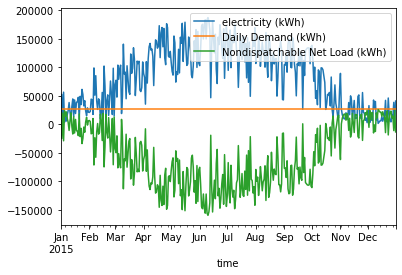

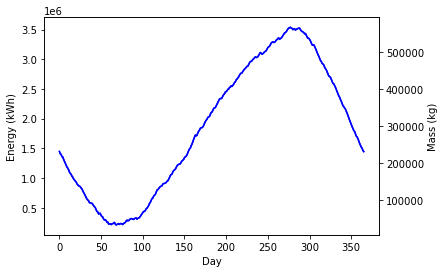

In [19]:
# A piece of code which models hydrogen and ammonia storage separately
# Import all the necessary packages
from dataclasses import dataclass
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import some data
df_epr1MW= pd.read_csv("Nottingham_2015.csv", index_col=0,parse_dates=True,dayfirst=True, delimiter=",")

#import value used to turn area into power capacity
power_intensity_epr = 90 #W/m2
#use function to lump into useful class

#INPUTS: 1MW hourly dataframe, capacity (W), power intensity W/m^2)
#OUTPUTS: dataframes with specified capacity, annual output, area of that capacity
def Produce_PV_Farm_Structure(DF_HOUR_1MW,CAPACITY,POWER_INTENSITY):
    
    
    capacity_ratio = int(CAPACITY/1e6) #capacity in MW

    #scale up 1MW data figure
    DF_HOUR=DF_HOUR_1MW.multiply(capacity_ratio)
    
    DF_DAY = DF_HOUR.resample("D").sum()
    DF_YEAR = DF_HOUR.resample("Y").sum()
    ANNUAL_OUTPUT = DF_YEAR["electricity (kWh)"].item()
    AREA = CAPACITY/(POWER_INTENSITY)


    @dataclass
    class User(NamedTuple):
        name: str


    # determine the different aspects of the PV_Farm, and the nature of each aspect (float, string etc)
    class PV_Farm(NamedTuple):
        #capacity in W
        Capacity: float
        #dataframe of hourly output
        df_hour: pd.DataFrame
        #dataframe of daily output
        df_day: pd.DataFrame
        #annual production of energy (kWh)
        Annual_Output: float
        #area in metres squared
        Area: float

    PV_Farm_Out = PV_Farm(Capacity=CAPACITY,df_hour=DF_HOUR,df_day=DF_DAY,Annual_Output=ANNUAL_OUTPUT,Area=AREA)

    return PV_Farm_Out

#as example, make class for a 1MW plant
capacity_epr1MW = 1e6 #W
PV_Epr1MW = Produce_PV_Farm_Structure(df_epr1MW,capacity_epr1MW,power_intensity_epr)
#annual demand in Wh; this is the electrical energy which is required for the trains over the course of a year
Annual_Demand_end = 10e6 # =10GWh a year

#daily demand in Wh; this is the electrical energy needed by the trains every day
daily_demand_end = Annual_Demand_end/365

print(Annual_Demand_end)
print(daily_demand_end)

#turn into a vector of the same length as the daily df
NDays = len(PV_Epr1MW.df_day.index)
Daily_Demand_End_Vector = np.zeros(NDays)

for i in range(0,NDays):
    Daily_Demand_End_Vector[i] = daily_demand_end
    i+=1

Daily_Demand_End_List = list(Daily_Demand_End_Vector)

#lump into one dataframe
PV_Epr1MW_supp_demand = PV_Epr1MW.df_day
PV_Epr1MW_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List

PV_Epr1MW_supp_demand['electricity (kWh)'][50]

capacity_a = 28e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()






ratio=[]
ratio1=[]
ratio2=[]
capacity=[]
h_stored2=[]
h_stored2=np.zeros((366,1))
h_max=[]
nh3_max=[]
h_max=np.zeros((20,1))
nh3_max=np.zeros((20,1))
for j in range(30,31,1):
    capacity_a = j*1e6#starting point for capacity of solar farm
    PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
    PV_a_supp_demand = PV_a.df_day
    PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
    PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
    x=0
    x1=0
    x2=0

    demand=15.09e6  #assume to be 15GWh
    daily_H2_demand=demand/365

    capacity.append(j)

    for i in range(365):
        if PV_a_supp_demand['electricity (kWh)'][i]/1.786<daily_H2_demand:
                x=x+1
    y=(365-x+30)/365
    ratio.append(y)
        

        
    h_stored2[0]=30*daily_H2_demand
    for i in range(365):
        daily_h=0 #kwh
        daily_less=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_stored2[i+1]= h_stored2[i]+daily_excess*0.479

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            h_stored2[i+1]= h_stored2[i]-daily_less
        h_stored2[i+1]=h_stored2[i+1]*0.995
        if  h_stored2[i]<=0:
            x1=x1+1
            h_stored2[i]=0
    y1=(365-x1)/365
    ratio1.append(y1)
    
    
    
    h_stored=np.zeros((366,1))
    h_stored[0]=2*daily_H2_demand
    nh3_produced=np.zeros((366,1))
    nh3_produced[0]=0
    defficit=[]
    h_produced=np.zeros((366,1))
    h_produced[0]=0

    nh3_4=np.zeros((366,1))     #kwh
    nh3_4[0]=35*daily_H2_demand

    for i in range(365):
        daily_nh3=0 #kwh
        daily_h=0 #kwh
        daily_less=0
        x=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.75
            #not enough h2 for 14 days
            if 2*daily_H2_demand>h_stored[i]:
                daily_nh3=0   
                daily_h=daily_excess*0.479
                x=h_stored[i]+daily_h
                nh3_4[i+1]=nh3_4[i]
                h_stored[i+1]=x

            if 2*daily_H2_demand<=h_stored[i]:
                excess_h_stored=(h_stored[i]-2*daily_H2_demand)/33.33   #kg
                daily_nh3=(daily_excess)*0.32  #kwh
                daily_nh3_mass=daily_nh3/6.25         #kg
                if excess_h_stored> daily_nh3_mass/17*2:
                        nh3_4[i+1]=nh3_4[i]+daily_nh3
                        daily_h=-daily_nh3_mass/17*2*33.33*0.7
                        x=h_stored[i]+daily_h
                        h_stored[i+1]=x
                        
                    #not enough h2 in storage for production
                if excess_h_stored<= daily_nh3_mass/17*2:
                        nh3_4[i+1]=nh3_4[i]+excess_h_stored*33.33
                        x=h_stored[i]+daily_excess-excess_h_stored*33.33
                        h_stored[i+1]=x
                        h_produced[i+1]=daily_H2_demand+daily_excess*0.56-excess_h_stored*17/2/0.56
            nh3_produced[i+1]=daily_nh3

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            daily_nh3=0
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.56
            if nh3_4[i]>daily_less:
                nh3_4[i+1]=-daily_less+nh3_4[i]
                h_stored[i+1]=h_stored[i]
            if nh3_4[i]<=daily_less:
                daily_h=-daily_less+nh3_4[i]
                nh3_4[i+1]=0
                x=h_stored[i]+daily_h
                h_stored[i+1]=x
            nh3_produced[i+1]=daily_nh3
        h_stored[i+1]=h_stored[i+1]*0.995
        if  h_stored[i]<=0:
            x2=x2+1
            h_stored[i]=0
            print('oh no')
    y2=(365-x2)/365
    ratio2.append(y2)



fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(Ndays, nh3_4, 'b-')
ax2.plot(Ndays, nh3_4/6.25, 'b-')

ax1.set_xlabel('Day')
ax1.set_ylabel('Energy (kWh)', color='k')
ax2.set_ylabel('Mass (kg)', color='k')

plt.show()



10000000.0
27397.260273972603


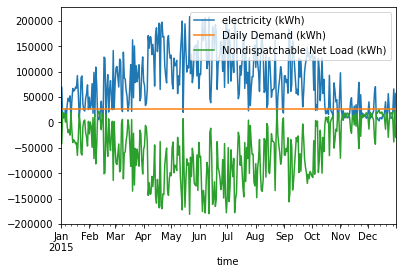

<Figure size 7200x4800 with 0 Axes>

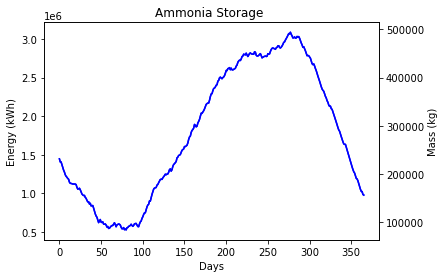

In [38]:
# A piece of code which models hydrogen and ammonia storage separately
# Import all the necessary packages
from dataclasses import dataclass
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import some data
df_epr1MW= pd.read_csv("ninja_pv_eynsham_PR_1MW.csv", index_col=0,parse_dates=True,dayfirst=True, delimiter=",")

#import value used to turn area into power capacity
power_intensity_epr = 90 #W/m2
#use function to lump into useful class

#INPUTS: 1MW hourly dataframe, capacity (W), power intensity W/m^2)
#OUTPUTS: dataframes with specified capacity, annual output, area of that capacity
def Produce_PV_Farm_Structure(DF_HOUR_1MW,CAPACITY,POWER_INTENSITY):
    
    
    capacity_ratio = int(CAPACITY/1e6) #capacity in MW

    #scale up 1MW data figure
    DF_HOUR=DF_HOUR_1MW.multiply(capacity_ratio)
    
    DF_DAY = DF_HOUR.resample("D").sum()
    DF_YEAR = DF_HOUR.resample("Y").sum()
    ANNUAL_OUTPUT = DF_YEAR["electricity (kWh)"].item()
    AREA = CAPACITY/(POWER_INTENSITY)


    @dataclass
    class User(NamedTuple):
        name: str


    # determine the different aspects of the PV_Farm, and the nature of each aspect (float, string etc)
    class PV_Farm(NamedTuple):
        #capacity in W
        Capacity: float
        #dataframe of hourly output
        df_hour: pd.DataFrame
        #dataframe of daily output
        df_day: pd.DataFrame
        #annual production of energy (kWh)
        Annual_Output: float
        #area in metres squared
        Area: float

    PV_Farm_Out = PV_Farm(Capacity=CAPACITY,df_hour=DF_HOUR,df_day=DF_DAY,Annual_Output=ANNUAL_OUTPUT,Area=AREA)

    return PV_Farm_Out

#as example, make class for a 1MW plant
capacity_epr1MW = 1e6 #W
PV_Epr1MW = Produce_PV_Farm_Structure(df_epr1MW,capacity_epr1MW,power_intensity_epr)
#annual demand in Wh; this is the electrical energy which is required for the trains over the course of a year
Annual_Demand_end = 10e6 # =10GWh a year

#daily demand in Wh; this is the electrical energy needed by the trains every day
daily_demand_end = Annual_Demand_end/365

print(Annual_Demand_end)
print(daily_demand_end)

#turn into a vector of the same length as the daily df
NDays = len(PV_Epr1MW.df_day.index)
Daily_Demand_End_Vector = np.zeros(NDays)

for i in range(0,NDays):
    Daily_Demand_End_Vector[i] = daily_demand_end
    i+=1

Daily_Demand_End_List = list(Daily_Demand_End_Vector)

#lump into one dataframe
PV_Epr1MW_supp_demand = PV_Epr1MW.df_day
PV_Epr1MW_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List

PV_Epr1MW_supp_demand['electricity (kWh)'][50]

capacity_a = 28e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()






ratio=[]
ratio1=[]
ratio2=[]
capacity=[]
h_stored2=[]
h_stored2=np.zeros((366,1))
h_max=[]
nh3_max=[]
h_max=np.zeros((20,1))
nh3_max=np.zeros((20,1))
for j in range(30,31,1):
    capacity_a = j*1e6#starting point for capacity of solar farm
    PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
    PV_a_supp_demand = PV_a.df_day
    PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
    PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
    x=0
    x1=0
    x2=0

    demand=15.09e6  #assume to be 15GWh
    daily_H2_demand=demand/365

    capacity.append(j)

    for i in range(365):
        if PV_a_supp_demand['electricity (kWh)'][i]/1.786<daily_H2_demand:
                x=x+1
    y=(365-x+30)/365
    ratio.append(y)
        

        
    h_stored2[0]=30*daily_H2_demand
    for i in range(365):
        daily_h=0 #kwh
        daily_less=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_stored2[i+1]= h_stored2[i]+daily_excess*0.479

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            h_stored2[i+1]= h_stored2[i]-daily_less
        h_stored2[i+1]=h_stored2[i+1]*0.995
        if  h_stored2[i]<=0:
            x1=x1+1
            h_stored2[i]=0
    y1=(365-x1)/365
    ratio1.append(y1)
    
    
    
    h_stored=np.zeros((366,1))
    h_stored[0]=2*daily_H2_demand
    nh3_produced=np.zeros((366,1))
    nh3_produced[0]=0
    defficit=[]
    h_produced=np.zeros((366,1))
    h_produced[0]=0

    nh3=np.zeros((366,1))     #kwh
    nh3[0]=35*daily_H2_demand

    for i in range(365):
        daily_nh3=0 #kwh
        daily_h=0 #kwh
        daily_less=0
        x=0
        if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
            daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.75
            #not enough h2 for 14 days
            if 2*daily_H2_demand>h_stored[i]:
                daily_nh3=0   
                daily_h=daily_excess*0.479
                x=h_stored[i]+daily_h
                nh3[i+1]=nh3[i]
                h_stored[i+1]=x

            if 2*daily_H2_demand<=h_stored[i]:
                excess_h_stored=(h_stored[i]-2*daily_H2_demand)/33.33   #kg
                daily_nh3=(daily_excess)*0.32  #kwh
                daily_nh3_mass=daily_nh3/6.25         #kg
                if excess_h_stored> daily_nh3_mass/17*2:
                        nh3[i+1]=nh3[i]+daily_nh3
                        daily_h=-daily_nh3_mass/17*2*33.33*0.7
                        x=h_stored[i]+daily_h
                        h_stored[i+1]=x
                        
                    #not enough h2 in storage for production
                if excess_h_stored<= daily_nh3_mass/17*2:
                        nh3[i+1]=nh3[i]+excess_h_stored*33.33
                        x=h_stored[i]+daily_excess-excess_h_stored*33.33
                        h_stored[i+1]=x
                        h_produced[i+1]=daily_H2_demand+daily_excess*0.56-excess_h_stored*17/2/0.56
            nh3_produced[i+1]=daily_nh3

        if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
            daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
            daily_nh3=0
            h_produced[i+1]=PV_a_supp_demand['electricity (kWh)'][i]*0.56
            if nh3[i]>daily_less:
                nh3[i+1]=-daily_less+nh3[i]
                h_stored[i+1]=h_stored[i]
            if nh3[i]<=daily_less:
                daily_h=-daily_less+nh3[i]
                nh3[i+1]=0
                x=h_stored[i]+daily_h
                h_stored[i+1]=x
            nh3_produced[i+1]=daily_nh3
        h_stored[i+1]=h_stored[i+1]*0.995
        if  h_stored[i]<=0:
            x2=x2+1
            h_stored[i]=0
            print('oh no')
    y2=(365-x2)/365
    ratio2.append(y2)


plt.figure(dpi=1200)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(Ndays, nh3, 'b-')
ax2.plot(Ndays, nh3/6.25, 'b-')

ax1.set_xlabel('Days')
ax1.set_ylabel('Energy (kWh)', color='k')
ax2.set_ylabel('Mass (kg)', color='k')
plt.title("Ammonia Storage ")
plt.show()



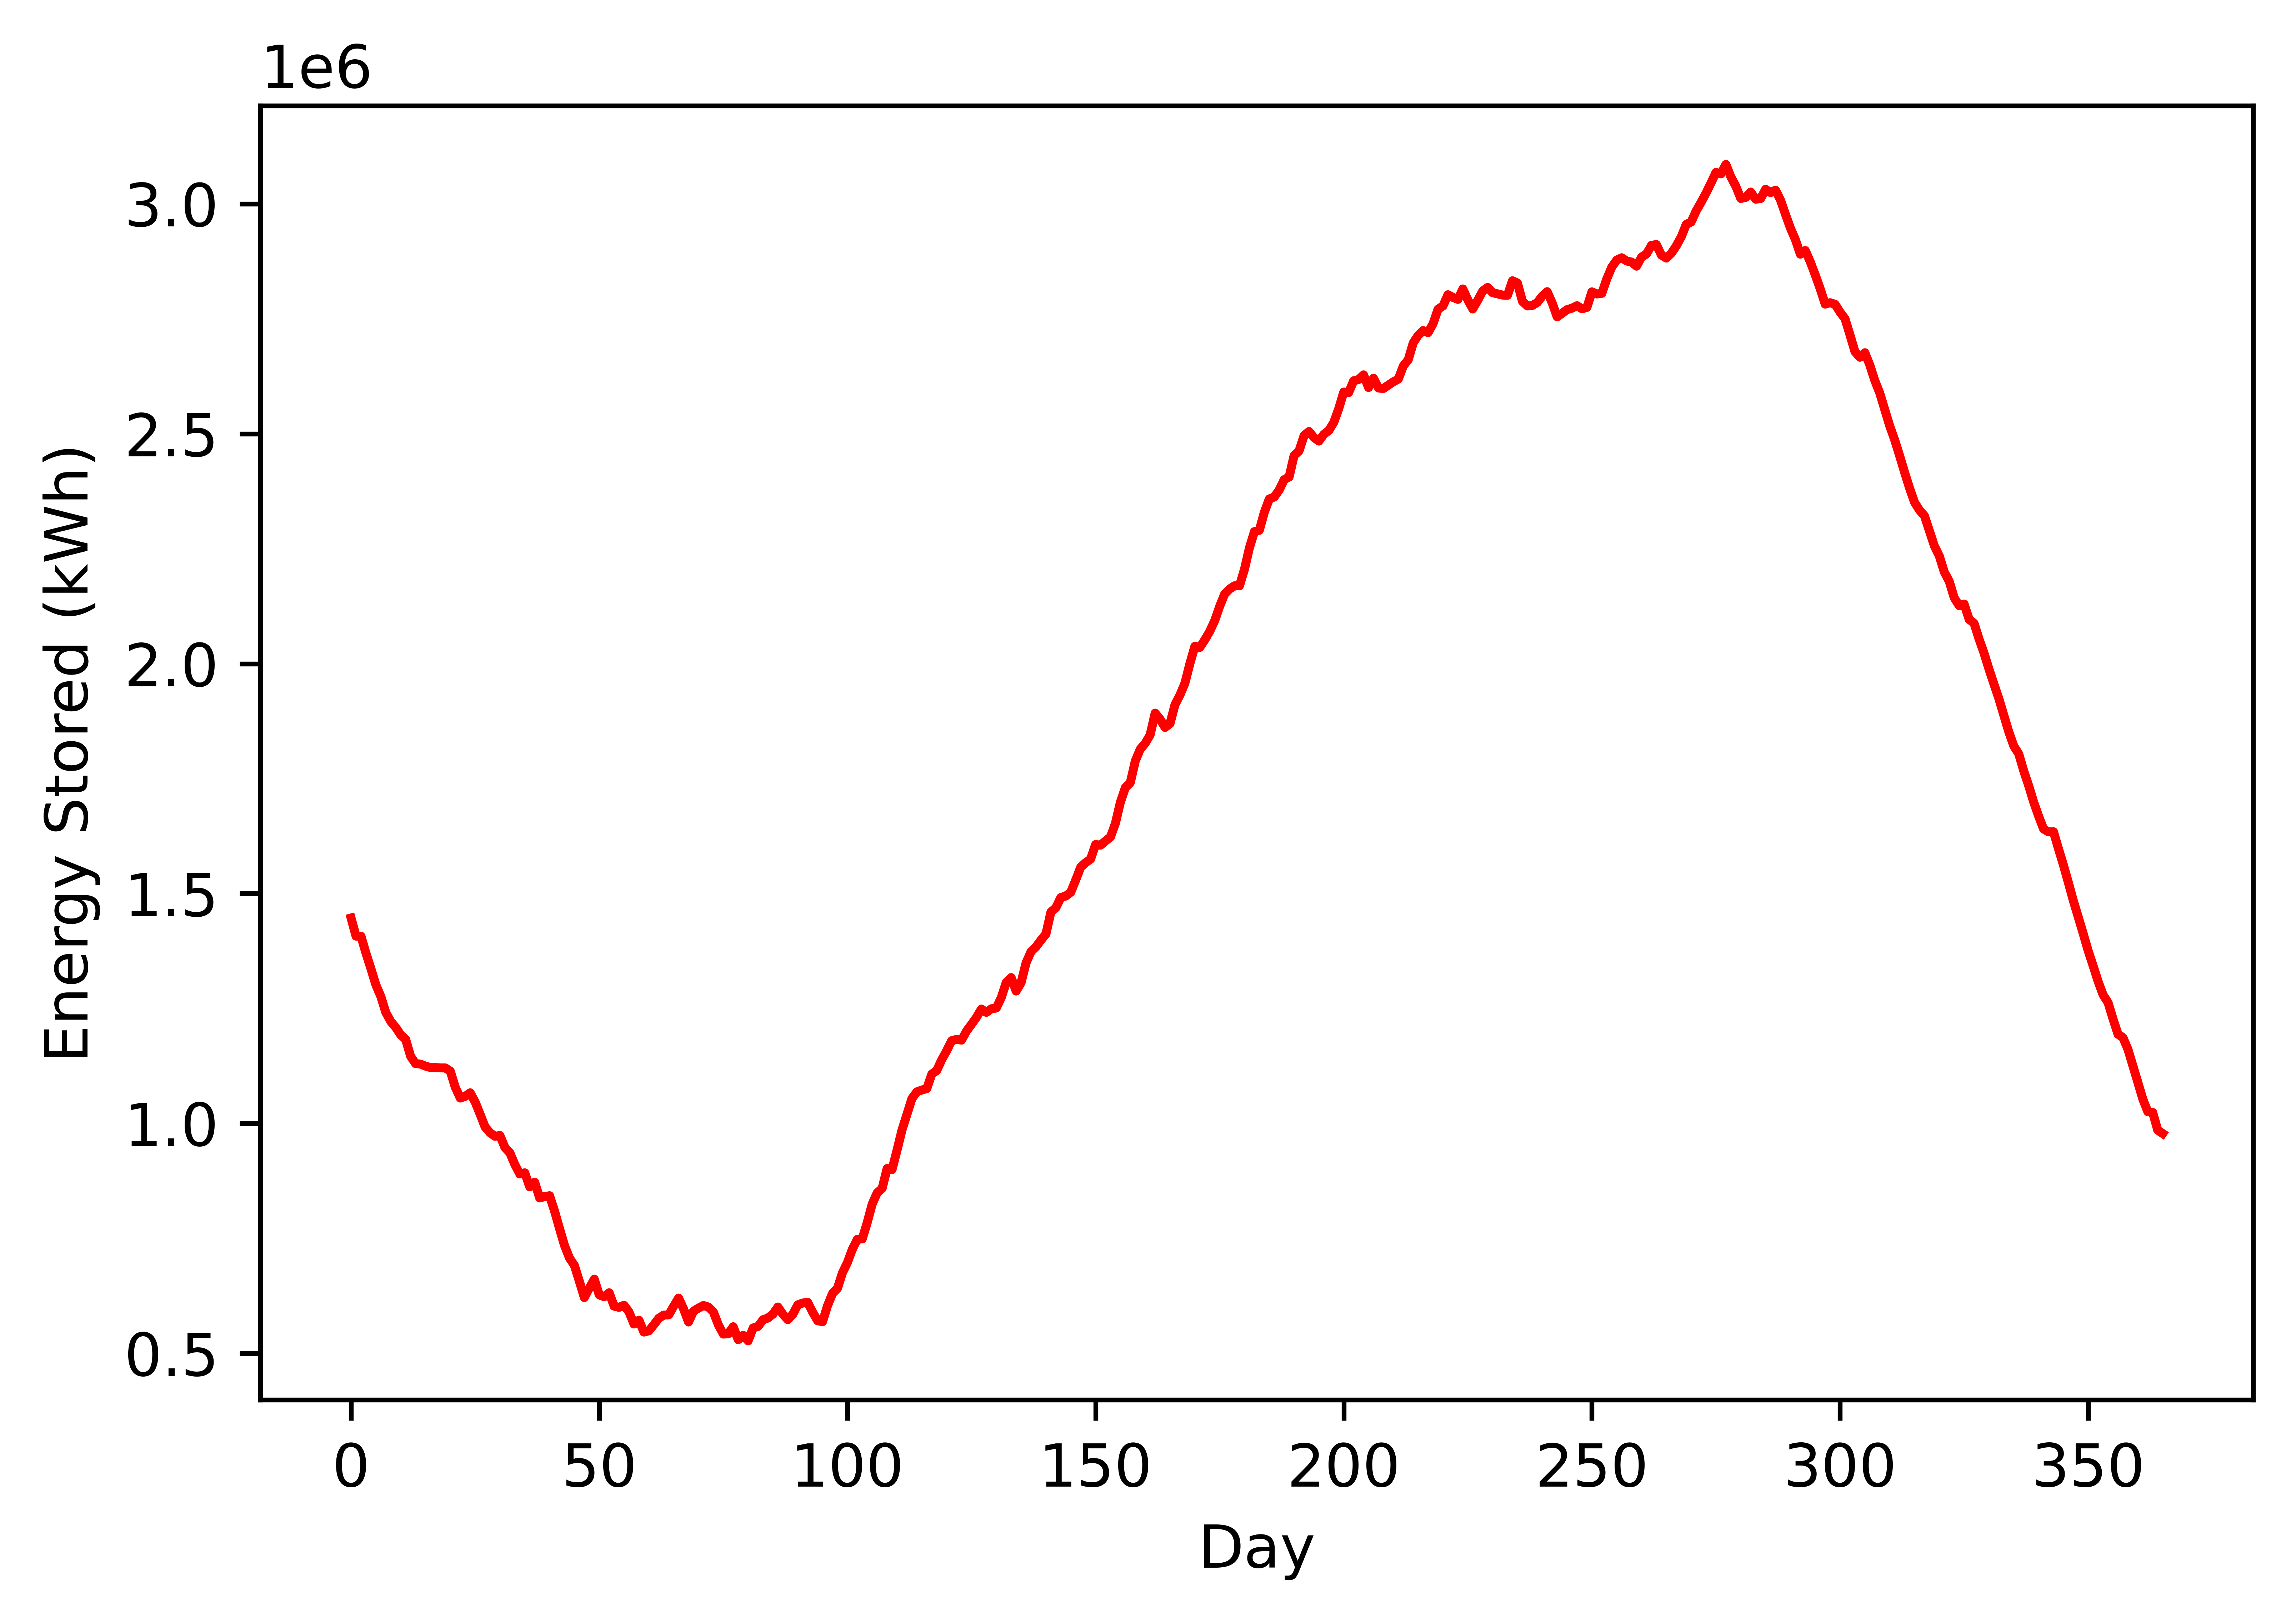

In [35]:
plt.figure(dpi=1200)
plt.plot(Ndays,nh3,color='r', label='Oxford-2015')
plt.plot(Ndays,nh3_1,color='g', label='Oxford-2018')
plt.plot(Ndays,nh3_2,color='b', label='Oxford-2020')
plt.plot(Ndays,nh3_3,color='m', label='Birmingham-2015')
plt.plot(Ndays,nh3_4,color='c', label='Nottingham-2015')
# Naming the x-axis, y-axis and the whole graph

plt.xlabel("Day")
plt.ylabel("Energy Stored (kWh)")

  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc='upper left')
plt.tick_params(top='on', right='on', which='both')  

# To load the display window
plt.show()

# To load the display window
plt.show()
